In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def load_regression_results(json_path):
    """Load regression results from JSON file."""
    with open(json_path, 'r') as f:
        return json.load(f)

def calculate_margins(coefficients, x_range, feature_name):
    """
    Calculate predicted values and confidence intervals.
    
    Args:
        coefficients: Dictionary with coefficient estimates
        x_range: Array of x values to evaluate
        feature_name: Name of the main feature (without _squared)
    """
    # Get coefficients
    beta_1 = coefficients['estimates'][feature_name]['coefficient']
    beta_2 = coefficients['estimates'][f"{feature_name}_squared"]['coefficient']
    
    # Get covariance matrix
    cov_matrix = np.array(coefficients['covariance_matrix'])
    
    # Calculate predicted values (marginal effects)
    # For y = beta_1*x + beta_2*x^2, dy/dx = beta_1 + 2*beta_2*x
    marginal_effects = beta_1 + 2 * beta_2 * x_range
    
    # Calculate standard errors using delta method
    # Var(dy/dx) = Var(beta_1) + 4*x^2*Var(beta_2) + 4*x*Cov(beta_1, beta_2)
    var_marginal = (cov_matrix[0, 0] + 
                    4 * x_range**2 * cov_matrix[1, 1] + 
                    4 * x_range * cov_matrix[0, 1])
    se_marginal = np.sqrt(var_marginal)
    
    # Calculate 95% confidence intervals
    z_critical = 1.96
    ci_lower = marginal_effects - z_critical * se_marginal
    ci_upper = marginal_effects + z_critical * se_marginal
    
    return marginal_effects, ci_lower, ci_upper

def create_margins_plot(results_path, output_path=None, x_percentiles=(1, 99)):
    """
    Create a STATA-style margins plot.
    
    Args:
        results_path: Path to analysis_results.json
        output_path: Path to save the plot (optional)
        x_percentiles: Tuple of (min, max) percentiles for x-axis range
    """
    # Load results
    results = load_regression_results(results_path)
    
    # Extract feature name
    feature_name = results['metadata']['feature_variables'][0]
    
    # Generate x values for plotting
    # Using a reasonable range around 0 for demeaned data
    x_min, x_max = -3, 3  # Adjust based on your data distribution
    x_range = np.linspace(x_min, x_max, 100)
    
    # Calculate margins
    margins, ci_lower, ci_upper = calculate_margins(
        results['coefficients'], 
        x_range, 
        feature_name
    )
    
    # Create plot with STATA styling
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Set style
    sns.set_style("whitegrid")
    plt.rcParams['font.family'] = 'serif'
    
    # Plot confidence interval
    ax.fill_between(x_range, ci_lower, ci_upper, 
                     alpha=0.2, color='gray', 
                     label='95% CI')
    
    # Plot marginal effect
    ax.plot(x_range, margins, 
            linewidth=2, color='black', 
            label='Marginal Effect')
    
    # Add zero reference line
    ax.axhline(y=0, color='red', linestyle='--', 
               linewidth=1, alpha=0.7)
    
    # Labels and title
    ax.set_xlabel(f'{feature_name.replace("_", " ").title()}', 
                  fontsize=12, fontweight='bold')
    ax.set_ylabel('Marginal Effect on ' + 
                  results['metadata']['target_variable'].replace('_', ' ').title(),
                  fontsize=12, fontweight='bold')
    ax.set_title('Average Marginal Effects with 95% CIs',
                 fontsize=14, fontweight='bold', pad=20)
    
    # Legend
    ax.legend(loc='best', frameon=True, shadow=True)
    
    # Grid styling
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Tight layout
    plt.tight_layout()
    
    # Save or show
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {output_path}")
    else:
        plt.show()
    
    return fig, ax

def create_predicted_values_plot(results_path, output_path=None):
    """
    Alternative: Plot predicted values instead of marginal effects.
    """
    # Load results
    results = load_regression_results(results_path)
    
    # Extract feature name and coefficients
    feature_name = results['metadata']['feature_variables'][0]
    beta_1 = results['coefficients']['estimates'][feature_name]['coefficient']
    beta_2 = results['coefficients']['estimates'][f"{feature_name}_squared"]['coefficient']
    
    # Generate x values
    x_range = np.linspace(-3, 3, 100)
    
    # Calculate predicted values
    y_pred = beta_1 * x_range + beta_2 * x_range**2
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.set_style("whitegrid")
    
    ax.plot(x_range, y_pred, linewidth=2, color='black')
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.7)
    
    ax.set_xlabel(f'{feature_name.replace("_", " ").title()}', 
                  fontsize=12, fontweight='bold')
    ax.set_ylabel('Predicted ' + 
                  results['metadata']['target_variable'].replace('_', ' ').title(),
                  fontsize=12, fontweight='bold')
    ax.set_title('Predicted Values',
                 fontsize=14, fontweight='bold', pad=20)
    
    ax.grid(True, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {output_path}")
    else:
        plt.show()
    
    return fig, ax

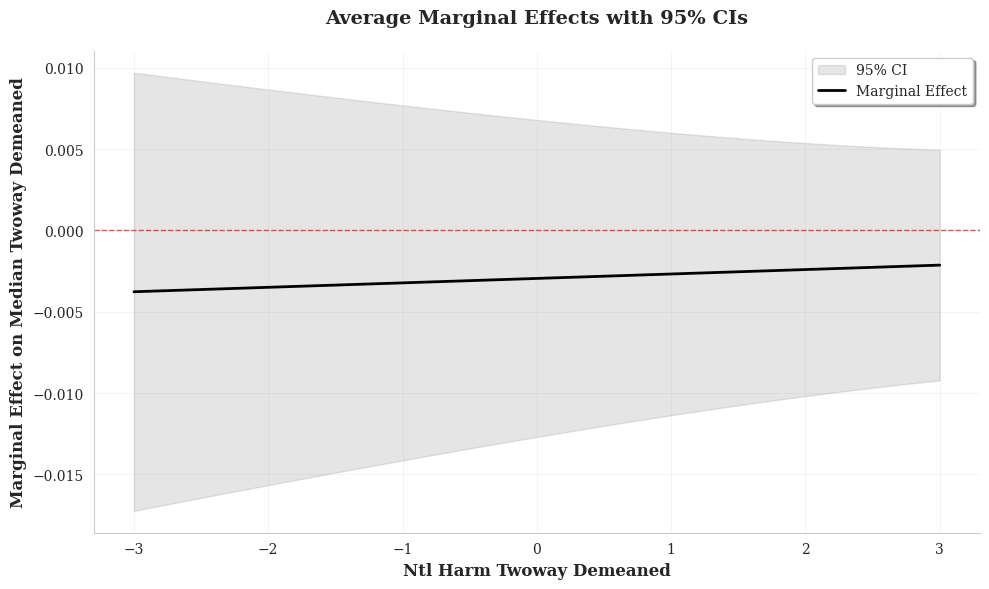

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Average Marginal Effects with 95% CIs'}, xlabel='Ntl Harm Twoway Demeaned', ylabel='Marginal Effect on Median Twoway Demeaned'>)

In [4]:
# Example usage
results_file = "../../output/analysis/modis_ntlharm_twfe_subset_20251001_113934/analysis_results.json"
output_dir = Path("output/analysis/modis_ntlharm_twfe_subset_20251001_113934")

# Create margins plot (marginal effects)
create_margins_plot(
    results_file
    )

In [ ]:
# Create predicted values plot
create_predicted_values_plot(
    results_file,
    output_path=output_dir / "predicted_values_plot.png"
)